In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import NO2_estimation
import importlib
importlib.reload(NO2_estimation)
from NO2_estimation import pre_scale_CNN,density_plot,plot_feature,combineno2_42,combineno2_sample42,today_impu,pre_no2_today,rowcol2indices,coeff_determination,lr_schedule,get_train_xy,clean_nan,plot_loss,x_y_scalar,date_list,today_impu

<module 'NO2_estimation' from '/Users/roxywang/Library/CloudStorage/OneDrive-connect.hku.hk/air pollution/ATP-thesis/Mac 出图/chapter 5 DL/NO2_estimation.py'>

In [3]:
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
# from keras import backend as K
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime 
import seaborn as sns
import joblib
import pickle

In [28]:
combined_X=np.load(r'/Volumes/My Passport/London_CODE/NO2_estimation/combined_X2019_v2.npy')
combined_y=np.load(r'/Volumes/My Passport/London_CODE/NO2_estimation/combined_y2019_v2.npy')
indices=np.load(r'/Volumes/My Passport/London_CODE/NO2_estimation/indices2019_v2.npy')

In [29]:
combined_X,scalerr=x_y_scalar(combined_X)
combined_X=combined_X.reshape(-1,7,7,42)

In [30]:
# Set random seed for reproducibility (optional)
np.random.seed(26)
# Assuming matrix1, matrix2, and matrix3 have the same number of rows (dimension along axis 0)
num_rows = indices.shape[0]
# Generate a random set of indices for shuffling
shuffled_indices = np.random.permutation(num_rows)
# Shuffle the rows of each matrix using the shuffled indices
shuffled_g5indices = indices[shuffled_indices]
shuffled_combined_X = combined_X[shuffled_indices]
shuffled_combined_y = combined_y[shuffled_indices]

In [6]:
filtered_no2UK=pd.read_csv('/Volumes/My Passport/London_CODE/NO2_2019group5_sample_tra.csv', index_col=0)

In [7]:
# Assuming you have a list of group numbers, for example: [1, 2, 3, 4, 5]
group_numbers = [1, 2, 3, 4, 5]

# Create dictionaries to store the indices for each group
train_indices_dict = {}
valid_indices_dict = {}

for group_num in group_numbers:
    # Filter the DataFrame for the current group
    group_data = filtered_no2UK[filtered_no2UK['group'] == group_num]
    
    # Compute the count of each 'site_type' within the current group
    group_count = group_data['site_type'].value_counts()
    
    # Define the sample ratios for the current group based on desired sample sizes
    sample_ratios = {
        'Urban Traffic': 0.9,#1000 / group_count['Urban Traffic'],
        'Urban Background': 1, # 4000 / group_count['Urban Background'],
        'Rural Background': 1,#800 / group_count['Rural Background'],
        'Urban Industrial': 1,#9 / 10,
        'Suburban Industrial': 1,#  9 / 10,
        'unknown unknown': 1,# 9 / 10,
        'Suburban Background': 1,#9 / 10,
        'Rural Traffic': 1,#9 / 10,
    }
    # 这里不同sitetype内部shuffle了，但是不同类别之间并没有shuffle
    # Perform stratified sampling for each class in 'site_type' column
    train_data = pd.DataFrame()
    for class_name, count in sample_ratios.items():
        sampled_data = group_data[group_data['site_type'] == class_name].sample(frac=count, random_state=42)
        train_data = pd.concat([train_data, sampled_data])
    
    # Save the indices of train_data for the current group
    train_indices_dict[group_num] = train_data.index
    
    # Save the indices of valid_data (remaining data in group_data) for the current group
    valid_indices_dict[group_num] = group_data.drop(train_data.index).index


In [8]:
train_indices_dict

{1: Int64Index([  7618, 260761, 329923, 249004, 297755, 288676, 288717,  33475,
              53415,  19888,
             ...
             222772, 222438, 222695, 222540, 222445, 222551, 222535, 222742,
             222509, 222693],
            dtype='int64', length=12172),
 2: Int64Index([ 51261,  12157, 237638, 217966,  90846,  31553, 214425,  40287,
             217660,  25116,
             ...
             222768, 222434, 222701, 222541, 222435, 222552, 222539, 222744,
             222503, 222694],
            dtype='int64', length=12140),
 3: Int64Index([ 35761, 110460, 110466,   1982,  70774,  31566,  76322, 101680,
              35826, 138417,
             ...
             222771, 222447, 222702, 222545, 222449, 222557, 222531, 222738,
             222514, 222698],
            dtype='int64', length=12162),
 4: Int64Index([101594, 337667, 111388,  12268,   7878, 279110,  29639, 225206,
             297540,  57592,
             ...
             222666, 222517, 222439, 222526, 2227

In [33]:
modelh5_path=f'./H5/res_ae_sample19_y42Nscale_mac.h5'
model_now = load_model(modelh5_path,custom_objects={"coeff_determination": coeff_determination })

In [31]:
test_without_nan,no2UKtt_without_nan=clean_nan(shuffled_combined_X,shuffled_combined_y)
scalarx,still_x6,still_x6t,still_x6v,still_23y,still_23yt,still_23yv=get_train_xy(test_without_nan,no2UKtt_without_nan,train_per=0.7,test_per=0.1,val_per=0.2,y_scale=False)

train sample is  0.7
val sample// test sample is   0.3333333333333333
(30440, 7, 7, 42) (8697, 7, 7, 42) (4349, 7, 7, 42)


In [32]:
from __future__ import print_function
import keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from keras import backend as K
from tensorflow.keras.models import Model

import models
from models import resnet_ae
import importlib
importlib.reload(resnet_ae)


base_model = 'resnetae'
# Choose what attention_module to use: cbam_block / se_block / None
attention_module ='cbam_block' # None #
model_type = base_model if attention_module==None else base_model+'_'+attention_module

# # Input image dimensions.
input_shape = still_x6.reshape(-1,7,7,42).shape[1:] #x_train.shape[1:]#

#depth = 38 #29 # For ResNet, specify the depth (e.g. ResNet50: depth=50)
# model = resnet_v1.resnet_v1(input_shape=input_shape, depth=depth, attention_module=attention_module)
modelae = resnet_ae.resnet_ae(input_shape=input_shape,attention_module=attention_module)   

from tensorflow.keras.optimizers.legacy import SGD,Adam

modelae.compile(loss='mse',
              optimizer=Adam(learning_rate=lr_schedule(0), beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=[coeff_determination])
modelae.summary()
print(model_type)

<module 'models.resnet_ae' from '/Users/roxywang/Library/CloudStorage/OneDrive-connect.hku.hk/air pollution/ATP-thesis/Mac 出图/chapter 5 DL/models/resnet_ae.py'>

Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 7, 7, 42)]   0           []                               
                                                                                                  
 encoder (Conv2D)               (None, 7, 7, 64)     24256       ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 7, 7, 64)    256         ['encoder[0][0]']                
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 7, 7, 64)     0           ['batch

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
def trainmodel(modelX, trainx,trainy,epochs = 180, batch_size = 64):
    checkpoint = ModelCheckpoint('./H5/res_ae_sample19_y42Nscale_mac_full.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)#ae4_201901_try1
    #checkpoint = ModelCheckpoint('./ae4_y1_32.h5', monitor='val_loss', verbose=0) # very good: ae4downscaling_y7_batch32_mse
    es = EarlyStopping(monitor='val_loss', mode='min',patience=30)
    lr_scheduler = LearningRateScheduler(lr_schedule)
    lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                                   cooldown=0,
                                   patience=5,
                                   min_lr=0.5e-6)
    history=modelX.fit([trainx,trainx[:,3,3,:]],trainy #[train_x2,otherinput],train_y2
              ,batch_size = batch_size
              ,epochs = epochs
              ,validation_split= 0.2
              # ,validation_data=([still_x6v,still_x6v[:,3,3,:]],still_23yv)
              #,shuffle='batch'
              ,callbacks=[checkpoint,es,lr_reducer, lr_scheduler]#
              ,verbose=0
            ) 
    return history

Learning rate:  0.001
Learning rate:  0.001

Epoch 1: val_loss improved from inf to 245.24179, saving model to ./H5/res_ae_sample19_y42Nscale_mac.h5
Learning rate:  0.001

Epoch 2: val_loss improved from 245.24179 to 54.36898, saving model to ./H5/res_ae_sample19_y42Nscale_mac.h5
Learning rate:  0.001

Epoch 3: val_loss did not improve from 54.36898
Learning rate:  0.001

Epoch 4: val_loss improved from 54.36898 to 45.59267, saving model to ./H5/res_ae_sample19_y42Nscale_mac.h5
Learning rate:  0.001

Epoch 5: val_loss improved from 45.59267 to 40.66986, saving model to ./H5/res_ae_sample19_y42Nscale_mac.h5
Learning rate:  0.001

Epoch 6: val_loss did not improve from 40.66986
Learning rate:  0.001

Epoch 7: val_loss improved from 40.66986 to 37.67411, saving model to ./H5/res_ae_sample19_y42Nscale_mac.h5
Learning rate:  0.001

Epoch 8: val_loss did not improve from 37.67411
Learning rate:  0.001

Epoch 9: val_loss did not improve from 37.67411
Learning rate:  0.001

Epoch 10: val_loss 

/Applications/anaconda/anaconda3/lib/python3.11/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)



Epoch 1: val_loss improved from inf to 80.42446, saving model to ./H5/res_ae_sample19_y42Nscale_mac.h5
Learning rate:  0.001

Epoch 2: val_loss improved from 80.42446 to 52.10975, saving model to ./H5/res_ae_sample19_y42Nscale_mac.h5
Learning rate:  0.001

Epoch 3: val_loss did not improve from 52.10975
Learning rate:  0.001

Epoch 4: val_loss did not improve from 52.10975
Learning rate:  0.001

Epoch 5: val_loss improved from 52.10975 to 40.04985, saving model to ./H5/res_ae_sample19_y42Nscale_mac.h5
Learning rate:  0.001

Epoch 6: val_loss did not improve from 40.04985
Learning rate:  0.001

Epoch 7: val_loss did not improve from 40.04985
Learning rate:  0.001

Epoch 8: val_loss improved from 40.04985 to 38.32791, saving model to ./H5/res_ae_sample19_y42Nscale_mac.h5
Learning rate:  0.001

Epoch 9: val_loss did not improve from 38.32791
Learning rate:  0.001

Epoch 10: val_loss improved from 38.32791 to 34.24599, saving model to ./H5/res_ae_sample19_y42Nscale_mac.h5
Learning rate:  

/Applications/anaconda/anaconda3/lib/python3.11/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)



Epoch 1: val_loss improved from inf to 132.02386, saving model to ./H5/res_ae_sample19_y42Nscale_mac.h5
Learning rate:  0.001

Epoch 2: val_loss improved from 132.02386 to 81.14934, saving model to ./H5/res_ae_sample19_y42Nscale_mac.h5
Learning rate:  0.001

Epoch 3: val_loss improved from 81.14934 to 68.00051, saving model to ./H5/res_ae_sample19_y42Nscale_mac.h5
Learning rate:  0.001

Epoch 4: val_loss improved from 68.00051 to 49.35160, saving model to ./H5/res_ae_sample19_y42Nscale_mac.h5
Learning rate:  0.001

Epoch 5: val_loss did not improve from 49.35160
Learning rate:  0.001

Epoch 6: val_loss improved from 49.35160 to 44.97284, saving model to ./H5/res_ae_sample19_y42Nscale_mac.h5
Learning rate:  0.001

Epoch 7: val_loss did not improve from 44.97284
Learning rate:  0.001

Epoch 8: val_loss improved from 44.97284 to 36.59095, saving model to ./H5/res_ae_sample19_y42Nscale_mac.h5
Learning rate:  0.001

Epoch 9: val_loss did not improve from 36.59095
Learning rate:  0.001

Epo

/Applications/anaconda/anaconda3/lib/python3.11/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)



Epoch 1: val_loss improved from inf to 84.68920, saving model to ./H5/res_ae_sample19_y42Nscale_mac.h5
Learning rate:  0.001

Epoch 2: val_loss improved from 84.68920 to 55.34436, saving model to ./H5/res_ae_sample19_y42Nscale_mac.h5
Learning rate:  0.001

Epoch 3: val_loss did not improve from 55.34436
Learning rate:  0.001

Epoch 4: val_loss did not improve from 55.34436
Learning rate:  0.001

Epoch 5: val_loss improved from 55.34436 to 50.12925, saving model to ./H5/res_ae_sample19_y42Nscale_mac.h5
Learning rate:  0.001

Epoch 6: val_loss improved from 50.12925 to 44.23686, saving model to ./H5/res_ae_sample19_y42Nscale_mac.h5
Learning rate:  0.001

Epoch 7: val_loss did not improve from 44.23686
Learning rate:  0.001

Epoch 8: val_loss did not improve from 44.23686
Learning rate:  0.001

Epoch 9: val_loss did not improve from 44.23686
Learning rate:  0.001

Epoch 10: val_loss did not improve from 44.23686
Learning rate:  0.001

Epoch 11: val_loss improved from 44.23686 to 43.65755

/Applications/anaconda/anaconda3/lib/python3.11/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)



Epoch 1: val_loss improved from inf to 79.45277, saving model to ./H5/res_ae_sample19_y42Nscale_mac.h5
Learning rate:  0.001

Epoch 2: val_loss improved from 79.45277 to 61.15675, saving model to ./H5/res_ae_sample19_y42Nscale_mac.h5
Learning rate:  0.001

Epoch 3: val_loss improved from 61.15675 to 50.25248, saving model to ./H5/res_ae_sample19_y42Nscale_mac.h5
Learning rate:  0.001

Epoch 4: val_loss improved from 50.25248 to 45.72969, saving model to ./H5/res_ae_sample19_y42Nscale_mac.h5
Learning rate:  0.001

Epoch 5: val_loss did not improve from 45.72969
Learning rate:  0.001

Epoch 6: val_loss did not improve from 45.72969
Learning rate:  0.001

Epoch 7: val_loss improved from 45.72969 to 43.59536, saving model to ./H5/res_ae_sample19_y42Nscale_mac.h5
Learning rate:  0.001

Epoch 8: val_loss did not improve from 43.59536
Learning rate:  0.001

Epoch 9: val_loss did not improve from 43.59536
Learning rate:  0.001

Epoch 10: val_loss improved from 43.59536 to 41.88932, saving mod

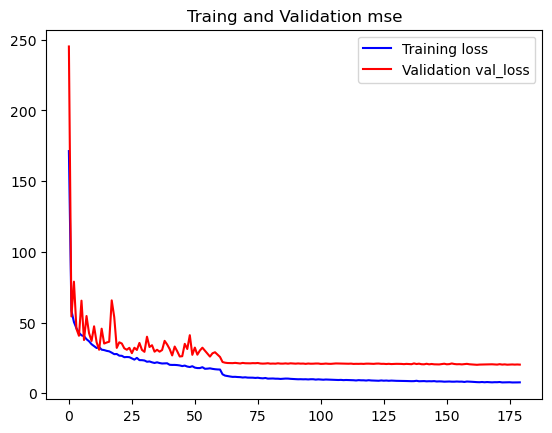

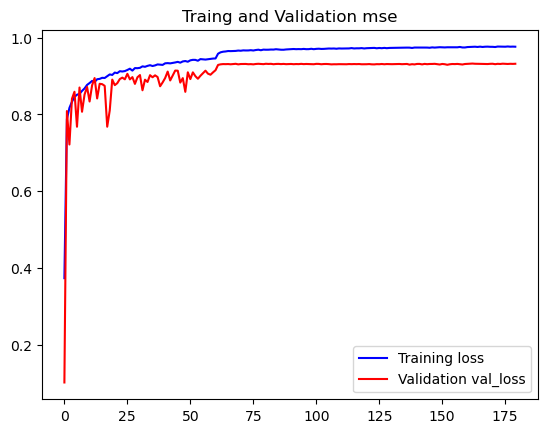

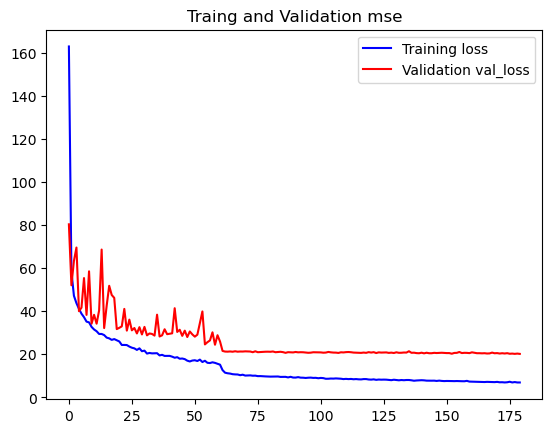

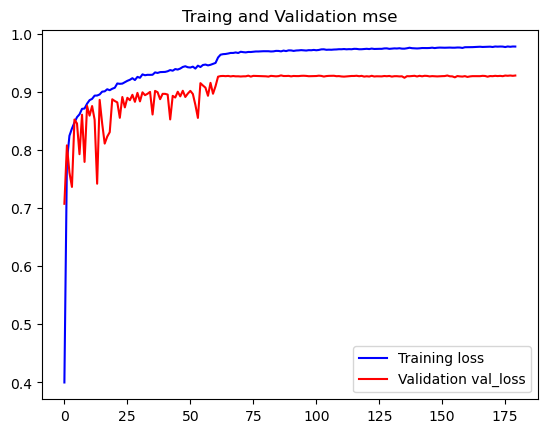

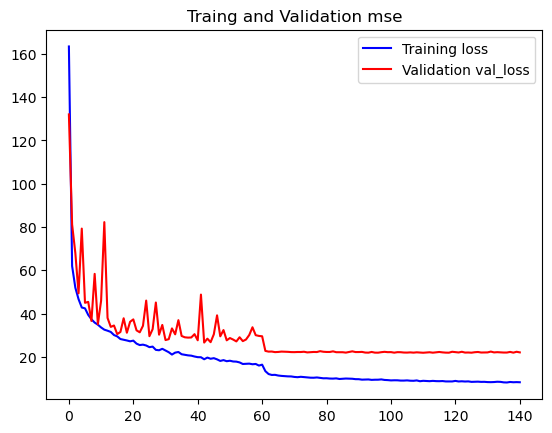

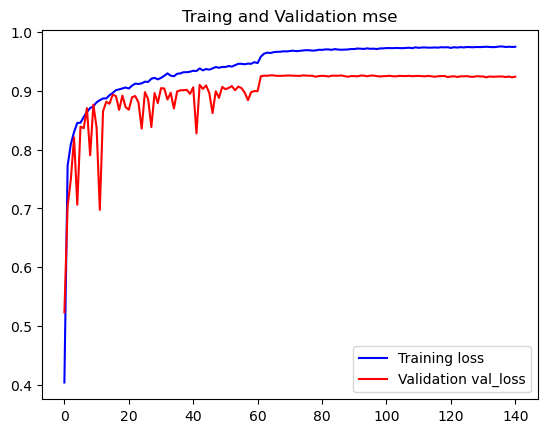

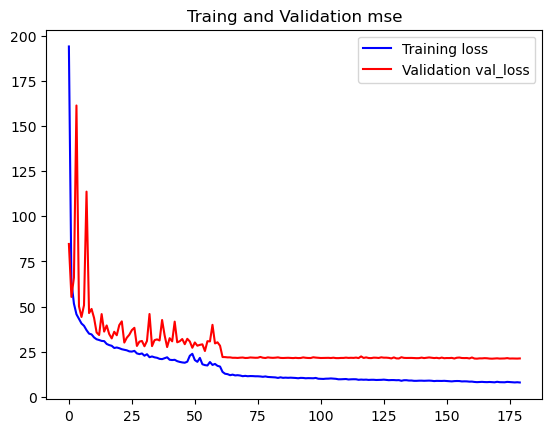

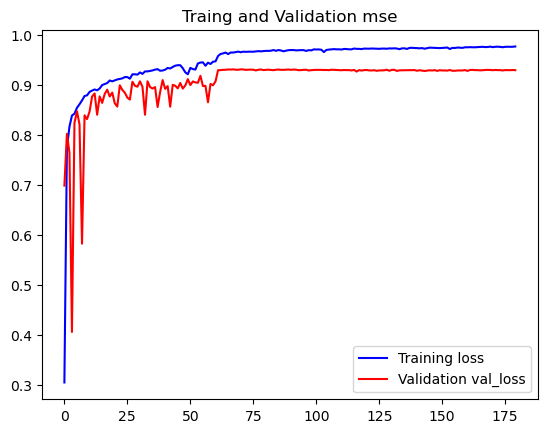

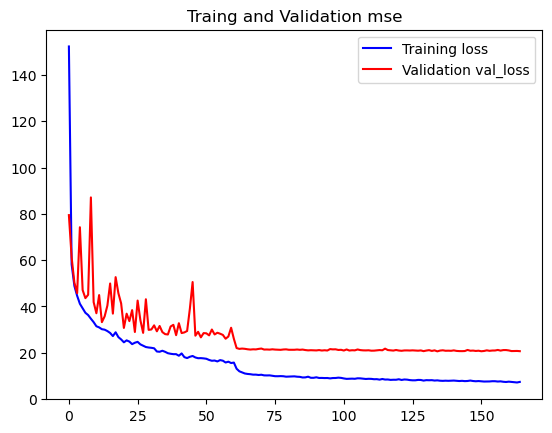

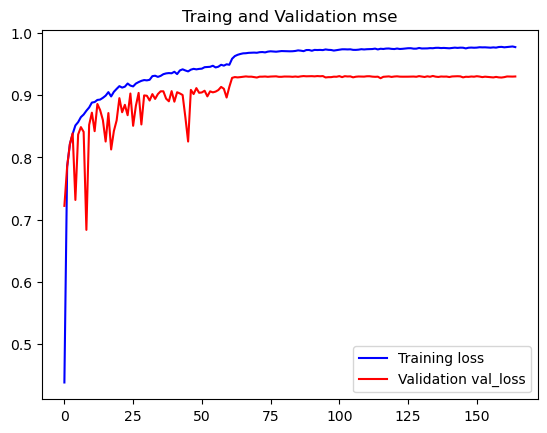

<Figure size 640x480 with 0 Axes>

In [21]:
average_mse =0
average_r2= 0
average_mae= 0
for group in range(5):
    test_indices = (shuffled_g5indices == group)
    X_test = shuffled_combined_X[test_indices]
    X_train = shuffled_combined_X[~test_indices]
    y_train = shuffled_combined_y[~test_indices]
    y_test = shuffled_combined_y[test_indices]

    # model = create_model()
    # model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    modelae = resnet_ae.resnet_ae(input_shape=input_shape,attention_module=attention_module)
    modelae.compile(loss='mse',
              optimizer=Adam(lr=lr_schedule(0), beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=[coeff_determination])
    history=trainmodel(modelae, X_train,y_train, epochs = 180, batch_size = 64)
    plot_loss(history)
    # Evaluate the model on the test set
    y_pred = modelae.predict([X_test,X_test[:,3,3,:]]) 
    # Evaluate the model on the test set
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print('mae:', mae)
    print('mse:', mse)
    print('r2:', r2)
    # Update average performance metrics
    average_mae += mae
    average_mse += mse
    average_r2 += r2

# Step 8: Compute average performance metrics
average_mse /= 5
average_r2 /= 5
average_mae /= 5

print("Average average_mae:", average_mae)
print("Average mse:", average_mse)
print("Average r2-score:", average_r2)

In [22]:
print("Average average_mae:", average_mae)
print("Average mse:", average_mse)
print("Average r2-score:", average_r2)

Average average_mae: 3.4053380231911468
Average mse: 23.991410430213637
Average r2-score: 0.9140773755618723


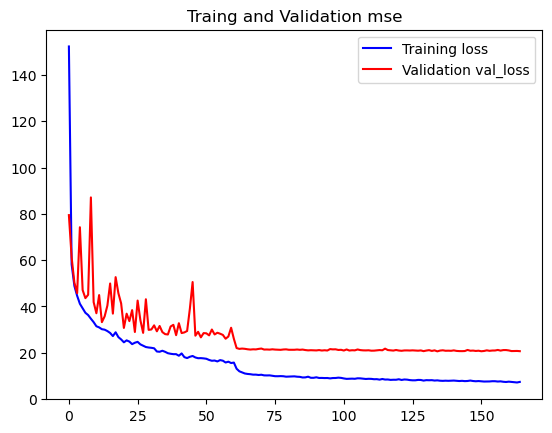

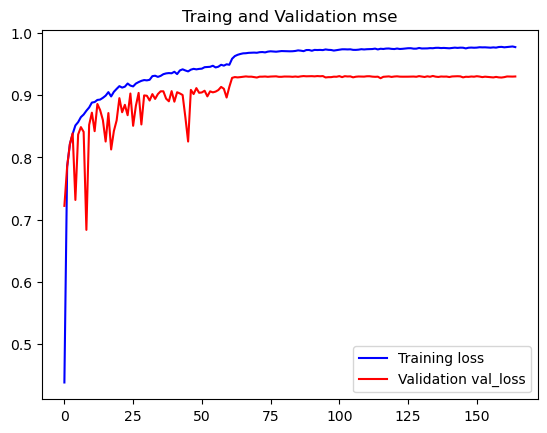

<Figure size 640x480 with 0 Axes>

In [59]:
plot_loss(history)

In [19]:
import pickle

# Assuming `history` is the object containing the loss and metric values

# Create a dictionary to store the values
saved_values = {
    'loss': history.history['loss'],
    'val_loss': history.history['val_loss'],
    'coeff_determination': history.history['coeff_determination'],
    'val_coeff_determination': history.history['val_coeff_determination']
}

# Save the dictionary to a file using pickle
with open('saved_history19.pkl', 'wb') as f:
    pickle.dump(saved_values, f)

In [13]:
# Load the saved values from the file
with open('saved_history19.pkl', 'rb') as f:
    loaded_values = pickle.load(f)

# Access the saved values
loss_values = loaded_values['loss']
val_loss_values = loaded_values['val_loss']
coeff_determination_values = loaded_values['coeff_determination']
coeff_determination_values = loaded_values['coeff_determination']

In [14]:
modelae.evaluate([still_x6t,still_x6t[:,3,3,:]],still_23yt)

272/272 [==============================] - 3s 9ms/step - loss: 21.9372 - coeff_determination: 0.9188


[21.937210083007812, 0.9187710881233215]

Text(0.5, 1.0, 'Traing and Validation mse')

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Traing and Validation mse')

<Figure size 640x480 with 0 Axes>

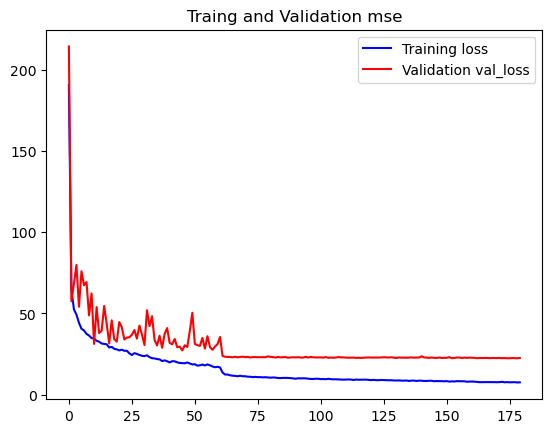

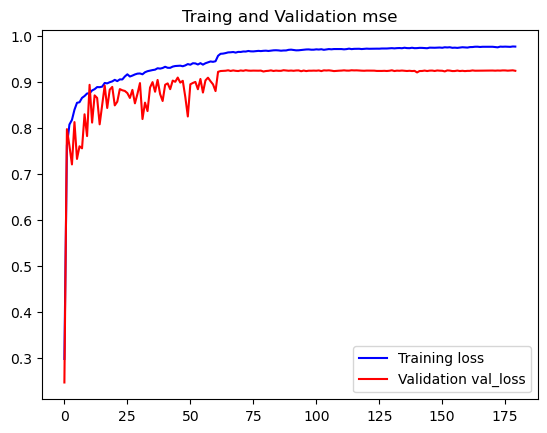

<Figure size 640x480 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt
plt.plot(range(len(loss_values)),loss_values,'b',label='Training loss')
plt.plot(range(len(val_loss_values)),val_loss_values,'r',label='Validation val_loss')
plt.title('Traing and Validation mse')
plt.legend()
plt.figure()
plt.plot(range(len(history.history['loss'])),history.history['coeff_determination'],'b',label='Training loss')
plt.plot(range(len(val_coeff_determination)),val_coeff_determination,'r',label='Validation val_loss')
plt.title('Traing and Validation mse')
plt.legend()
plt.figure()

In [16]:
y_pred = modelae.predict([still_x6t,still_x6t[:,3,3,:]])
# Evaluate the model on the test set
mse = mean_squared_error(still_23yt, y_pred)
r2 = r2_score(still_23yt, y_pred)
mae = mean_absolute_error(still_23yt, y_pred)
print('mae:', mae)
print('mse:', mse)
print('r2:', r2)

272/272 [==============================] - 2s 6ms/step
mae: 3.104067369053142
mse: 20.40810972763472
r2: 0.926158383122948


### RF

In [11]:
joblib.dump(rf_model, 'rf_model2021.pkl')

['rf_model2021.pkl']

In [7]:
# Step 1: Import necessary libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# # Step 2: Split data into features (X) and target (y)
# X = ...  # Your feature data
# y = ...  # Your target labels
best_params = {'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}

# Create the RandomForestRegressor with the best parameters
rf_model = RandomForestRegressor(
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    min_samples_leaf=best_params['min_samples_leaf'],
    min_samples_split=best_params['min_samples_split'],
    n_estimators=best_params['n_estimators']
)
# Step 3: Initialize the RandomForestClassifier with desired hyperparameters
# rf_model = RandomForestRegressor(n_estimators=100, random_state=24)

# Step 4: Use StratifiedKFold for 5-fold cross-validation
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Step 5: Train and validate the model on each fold
average_mse = 0
average_r2 = 0
average_mae=0

# fold_scores = []
for group in range(5):
    test_indices = (shuffled_g5indices == group)
    X_test = shuffled_combined_X[test_indices][:,3,3,:]
    X_train = shuffled_combined_X[~test_indices][:,3,3,:]
    y_train = shuffled_combined_y[~test_indices].ravel()
    y_test = shuffled_combined_y[test_indices].ravel()

    # Step 6: Train the model on four folds and validate on one fold
    rf_model.fit(X_train, y_train)

    # Step 7: Evaluate the model's performance on the validation fold
    y_pred = rf_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print('mae:', mae)
    print('mse:', mse)
    print('r2:', r2)


    # Update average performance metrics
    average_mae += mae
    average_mse += mse
    average_r2 += r2

# Step 8: Compute average performance metrics
average_mse /= 5
average_r2 /= 5
average_mae /= 5

print("Average average_mae:", average_mae)
print("Average mse:", average_mse)
print("Average r2-score:", average_r2)

/Applications/anaconda/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomForestRegressor(max_depth=30, max_features='auto', n_estimators=150)

mae: 3.983321024260216
mse: 33.708147921295726
r2: 0.8502014057722255


/Applications/anaconda/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomForestRegressor(max_depth=30, max_features='auto', n_estimators=150)

mae: 3.772252044455474
mse: 30.183226751627124
r2: 0.8576349496521682


/Applications/anaconda/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomForestRegressor(max_depth=30, max_features='auto', n_estimators=150)

mae: 3.9015973929015813
mse: 33.376490629784975
r2: 0.8489042322048993


/Applications/anaconda/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomForestRegressor(max_depth=30, max_features='auto', n_estimators=150)

mae: 3.915527884199371
mse: 32.93055250162206
r2: 0.8290297036623555


/Applications/anaconda/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomForestRegressor(max_depth=30, max_features='auto', n_estimators=150)

mae: 3.789282368725875
mse: 30.56146506083529
r2: 0.8358608863102132
Average average_mae: 3.872396142908504
Average mse: 32.15197657303304
Average r2-score: 0.8443262355203723


In [1]:
from sklearn.ensemble import RandomForestRegressor

### xgboost

In [10]:
joblib.dump(xg_model, 'xg_model2021.pkl')

['xg_model2021.pkl']

In [8]:
import xgboost as xgb
params={
        'eta':0.2,                        #特征权重，取值范围0~1，通常最后设置eta为0.01~0.2
        'max_depth':3,                    #树的深度，通常取值3-10，过大容易过拟合，过小欠拟合  230
        'min_child_weight':230,             #最小样本的权重，调大参数可以繁殖过拟合
        'gamma':0.4,                      #控制是否后剪枝，越大越保守，一般0.1、 0.2的样子
        'subsample':0.8,                  #随机取样比例
        'colsample_bytree':0.8 ,          #默认为1，取值0~1，对特征随机采集比例
        'lambda':0.8,
        'alpha':0.6,
        'n_estimators':500,
        'booster':'gbtree',               #迭代树
        'objective':'reg:squarederror',    #逻辑回归，输出为概率
        'nthread':6,                      #设置最大的进程量，若不设置则会使用全部资源
        'scale_pos_weight':3,             #默认为0,1可以处理类别不平衡

        'seed':1234,                      #随机树种子
        'silent':1,                       #0表示输出结果
        'eval_metric':'rmse' ,              #评分指标
        # 'feature_names':feature_name
    }

# Step 5: Train and validate the model on each fold
average_mse = 0
average_r2 = 0
average_mae = 0

# fold_scores = []
for group in range(5):
    test_indices = (shuffled_g5indices == group)
    X_test = shuffled_combined_X[test_indices][:,3,3,:]
    X_train = shuffled_combined_X[~test_indices][:,3,3,:]
    y_train = shuffled_combined_y[~test_indices].ravel()
    y_test = shuffled_combined_y[test_indices].ravel()

    # Step 6: Train the model on four folds and validate on one fold
    # rf_model.fit(X_train, y_train)
    xg_model = xgb.XGBRegressor(**params)
    xg_model.fit(X_train, y_train)#(x_cleaned, y_cleaned)

    # Step 7: Evaluate the model's performance on the validation fold
    y_pred = xg_model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print('mae:', mae)
    print('mse:', mse)
    print('r2:', r2)


    # Update average performance metrics
    average_mae += mae
    average_mse += mse
    average_r2 += r2

# Step 8: Compute average performance metrics
average_mse /= 5
average_r2 /= 5
average_mae /= 5

print("Average average_mae:", average_mae)
print("Average mse:", average_mse)
print("Average r2-score:", average_r2)

[17:48:59] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.



XGBRegressor(alpha=0.6, base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eta=0.2, eval_metric='rmse',
             feature_types=None, gamma=0.4, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None, lambda=0.8,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=230, missing=nan,
             monotone_constraints=None, n_estimators=500, n_jobs=None, ...)

mae: 4.3206718664823605
mse: 37.33799569225922
r2: 0.8340704069816443
[17:49:07] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.



XGBRegressor(alpha=0.6, base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eta=0.2, eval_metric='rmse',
             feature_types=None, gamma=0.4, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None, lambda=0.8,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=230, missing=nan,
             monotone_constraints=None, n_estimators=500, n_jobs=None, ...)

mae: 4.190354852982727
mse: 35.41206284526877
r2: 0.832972128812719
[17:49:15] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.



XGBRegressor(alpha=0.6, base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eta=0.2, eval_metric='rmse',
             feature_types=None, gamma=0.4, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None, lambda=0.8,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=230, missing=nan,
             monotone_constraints=None, n_estimators=500, n_jobs=None, ...)

mae: 4.379557230753608
mse: 39.288601283197714
r2: 0.8221400373596264
[17:49:24] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.



XGBRegressor(alpha=0.6, base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eta=0.2, eval_metric='rmse',
             feature_types=None, gamma=0.4, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None, lambda=0.8,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=230, missing=nan,
             monotone_constraints=None, n_estimators=500, n_jobs=None, ...)

mae: 4.248069993565796
mse: 36.19253764519611
r2: 0.8120939851796979
[17:49:33] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.



XGBRegressor(alpha=0.6, base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eta=0.2, eval_metric='rmse',
             feature_types=None, gamma=0.4, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None, lambda=0.8,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=230, missing=nan,
             monotone_constraints=None, n_estimators=500, n_jobs=None, ...)

mae: 4.1427575428288606
mse: 34.22401167258636
r2: 0.8161901292472361
Average average_mae: 4.25628229732267
Average mse: 36.491041827701636
Average r2-score: 0.8234933375161846
